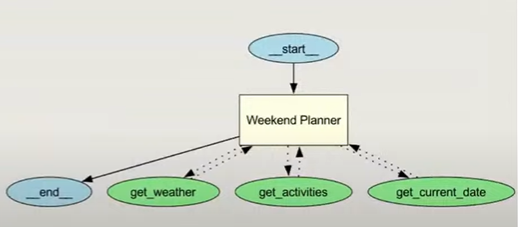

Modifications:
await main() Jupyter already has an event loop, so await is safe and clean
nest_asyncio.apply() Fixes issues when calling await multiple times inside notebook cells.
Remove __main__ block Not needed, since cells run automatically in notebook style.

In [2]:
import asyncio
import logging
import os
import random
from datetime import datetime

import azure.identity
import openai
from agents import Agent, OpenAIChatCompletionsModel, Runner, function_tool, set_tracing_disabled
from dotenv import load_dotenv
from rich.logging import RichHandler

import nest_asyncio
nest_asyncio.apply()

# Setup logging with rich
logging.basicConfig(level=logging.WARNING, format="%(message)s", datefmt="[%X]", handlers=[RichHandler()])
logger = logging.getLogger("weekend_planner")

# Disable tracing
set_tracing_disabled(disabled=True)

# Load environment variables
load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

# Setup OpenAI client
if API_HOST == "github":
    client = openai.AsyncOpenAI(
        base_url="https://models.inference.ai.azure.com", 
        api_key=os.environ["GITHUB_TOKEN"]
    )
    MODEL_NAME = os.getenv("GITHUB_MODEL", "gpt-4o")
elif API_HOST == "azure":
    token_provider = azure.identity.get_bearer_token_provider(
        azure.identity.DefaultAzureCredential(), 
        "https://cognitiveservices.azure.com/.default"
    )
    client = openai.AsyncAzureOpenAI(
        api_version=os.environ["AZURE_OPENAI_VERSION"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        azure_ad_token_provider=token_provider,
    )
    MODEL_NAME = os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"]

# Tools
@function_tool
def get_weather(city: str) -> str:
    logger.info(f"Getting weather for {city}")
    if random.random() < 0.05:
        return {
            "city": city,
            "temperature": 72,
            "description": "Sunny",
        }
    else:
        return {
            "city": city,
            "temperature": 60,
            "description": "Rainy",
        }

@function_tool
def get_activities(city: str, date: str) -> list:
    logger.info(f"Getting activities for {city} on {date}")
    return [
        {"name": "PLAY SOCCER", "location": city},
        {"name": "CHILLI AT HOME", "location": city},
        {"name": "STUDY TIME", "location": city},
    ]

@function_tool
def get_current_date() -> str:
    logger.info("Getting current date")
    return datetime.now().strftime("%Y-%m-%d")

# Agent
agent = Agent(
    name="Weekend Planner",
    instructions="You help users plan their weekends and choose the best activities for the given weather. Include the date of the week in your response.",
    tools=[get_weather, get_activities, get_current_date],
    model=OpenAIChatCompletionsModel(model=MODEL_NAME, openai_client=client),
)

# Main async function
async def main():
    result = await Runner.run(agent, input="hii what can I do this week in Vancouver ?")
    print(result.final_output)

# Run it
logger.setLevel(logging.INFO)
await main()


[16:30:11] INFO     Getting current date                                                           ]8;id=516468;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py\4199659470.py]8;;\:]8;id=958466;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py#74\74]8;;\

[16:30:13] INFO     Getting weather for Vancouver                                                  ]8;id=441392;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py\4199659470.py]8;;\:]8;id=594650;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py#49\49]8;;\

           INFO     Getting activities for Vancouver on 2025-05-10                                 ]8;id=331348;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py\4199659470.py]8;;\:]8;id=819951;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py#65\65]8;;\

This weekend in Vancouver (Saturday, May 10, 2025), the weather is expected to be rainy, with a temperature of 60°F. Here are some activity options:

1. **Play Soccer** - Stay active outdoors if the rain isn’t too heavy.
2. **Chill at Home** - Enjoy a relaxing day indoors, maybe watching your favorite shows or movies.
3. **Study Time** - Utilize the rainy day to focus on learning or catching up on any projects.

Let me know if you'd like specific recommendations or tips for any of these activities!
